# Lab 2: Cats vs Dogs

**Deadline**: May 28, 11:59pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**Marking TA**: Tinglin (Francis) Duan

This lab is partially based on an assignment developed by Prof. Jonathan Rose and Harris Chan.

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/10pK8uvpgOKnuenOsddiBuFin097trUb7?usp=sharing

In [0]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [0]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [10]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

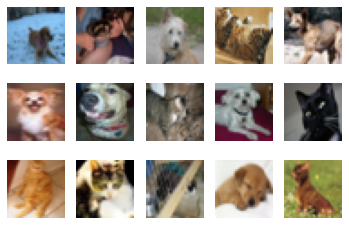

In [11]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [12]:
"""
classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

cats are index 3, dogs are index 5
"""

# animal indicies
dog_index = 5
cat_index = 3

# training examples
dog_train = 0
cat_train = 0

for images, labels in train_loader:
  if labels.item() == dog_index:
    dog_train += 1
  else:
    cat_train += 1

# validation examples
dog_val = 0
cat_val = 0

for images, labels in val_loader:
  if labels.item() == dog_index:
    dog_val += 1
  else:
    cat_val += 1

# testing examples
dog_test = 0
cat_test = 0

for images, labels in test_loader:
  if labels.item() == dog_index:
    dog_test += 1
  else:
    cat_test += 1

print("Dogs in training sample: {0}\t\tCats in training sample: {1}\t\tCombined size: {2}".format(dog_train, cat_train, len(train_loader)))
print("Dogs in validation sample: {0}\t\tCats in validation sample: {1}\t\tCombined size: {2}".format(dog_val, cat_val, len(val_loader)))
print("Dogs in testing sample: {0}\t\tCats in testing sample: {1}\t\tCombined size: {2}".format(dog_test, cat_test, len(test_loader)))

Dogs in training sample: 3982		Cats in training sample: 4018		Combined size: 8000
Dogs in validation sample: 1018		Cats in validation sample: 982		Combined size: 2000
Dogs in testing sample: 1000		Cats in testing sample: 1000		Combined size: 2000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

In [13]:
"""
The validation test ensures we are not overfitting onto the validation/testing data.
The network will naturally perform better on the training data but if the model becomes too complex, it will not learn the neseccary patterns to distinguish between classes across various datasets.
Using a validation test allows us to measure the performance of the model on data it was not trained with.
As such, the loss/error readings based on the validation sample are a better representative of how the model will perform on new data.
If the loss/error readings are based on model performance using training data, one may inaccurately judge the effectiveness and accuracy of their network.
"""

'\nThe validation test ensures we are not overfitting onto the validation/testing data.\nThe network will naturally perform better on the training data but if the model becomes too complex, it will not learn the neseccary patterns to distinguish between classes across various datasets.\nUsing a validation test allows us to measure the performance of the model on data it was not trained with.\nAs such, the loss/error readings based on the validation sample are a better representative of how the model will perform on new data.\nIf the loss/error readings are based on model performance using training data, one may inaccurately judge the effectiveness and accuracy of their network.\n'

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [0]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [0]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [0]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [17]:
small_net_size = 0
for param in small_net.parameters():
    print(param.shape)
    small_net_size += torch.numel(param)
print("Total number of parameters in small_net is " + str(small_net_size) + "\n")

large_net_size = 0
for param in large_net.parameters():
    print(param.shape)
    large_net_size += torch.numel(param)

print("Total number of parameters in large_net is " + str(large_net_size))

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])
Total number of parameters in small_net is 386

torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])
Total number of parameters in large_net is 9705


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [0]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

In [19]:
"""
batch_size=64
learning_rate=0.01
num_epochs=30
"""

'\nbatch_size=64\nlearning_rate=0.01\nnum_epochs=30\n'

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [20]:
"""
Each epoch has its network model saved to a file for later restoration; only the model's state_dict, a python dictionary storing its learnable parameters, needs to be saved
model_small_bs64_lr0.01_epoch5_train_err.csv stores the training error across epochs 
model_small_bs64_lr0.01_epoch5_train_loss.csv stores the training loss across epochs
model_small_bs64_lr0.01_epoch5_val_err.csv stores the validation error across epochs
model_small_bs64_lr0.01_epoch5_val_loss.csv stores the validation loss across epochs
"""

"\nEach epoch has its network model saved to a file for later restoration; only the model's state_dict, a python dictionary storing its learnable parameters, needs to be saved\nmodel_small_bs64_lr0.01_epoch5_train_err.csv stores the training error across epochs \nmodel_small_bs64_lr0.01_epoch5_train_loss.csv stores the training loss across epochs\nmodel_small_bs64_lr0.01_epoch5_val_err.csv stores the validation error across epochs\nmodel_small_bs64_lr0.01_epoch5_val_loss.csv stores the validation loss across epochs\n"

### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [21]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [188]:
# reset small_net and large_net (debugging purposes)
small_net = SmallNet()
large_net = LargeNet()

# train small_net
print("---SMALL NET---")
train_net(small_net)

print()

# train large_net
print("---LARGE NET---")
train_net(large_net)

"""
The large_net model took longer to train because this network contains more parameters tweakable by the algorithm (more layers and hidden units)
"""

---SMALL NET---
Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.439375, Train loss: 0.6837765421867371 |Validation err: 0.3915, Validation loss: 0.6662272289395332
Epoch 2: Train err: 0.380875, Train loss: 0.6527453322410584 |Validation err: 0.3935, Validation loss: 0.6626366525888443
Epoch 3: Train err: 0.342125, Train loss: 0.625328052520752 |Validation err: 0.3335, Validation loss: 0.6186922714114189
Epoch 4: Train err: 0.323875, Train loss: 0.6055600070953369 |Validation err: 0.339, Validation loss: 0.6171749532222748
Epoch 5: Train err: 0.314625, Train loss: 0.5930321733951569 |Validation err: 0.3215, Validation loss: 0.6096237320452929
Epoch 6: Train err: 0.29975, Train loss: 0.581014221906662 |Validation err: 0.3265, Validation loss: 0.6049923654645681
Epoch 7: Train err: 0.2975, Train loss: 0.5773153674602508 |Validation err: 0.3305, Validation loss: 0.600175685249269
Epoch 8: Train err: 0.295125, Train loss: 0.5693165059089661 

'\nThe large_net model took longer to train because this network contains more parameters tweakable by the algorithm (more layers and hidden units)\n'

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

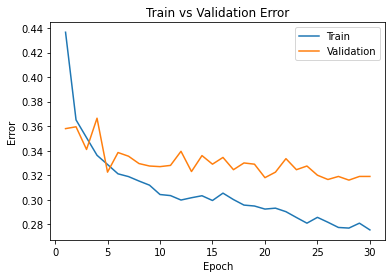

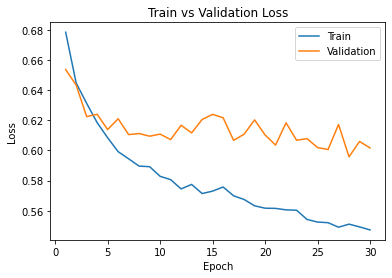

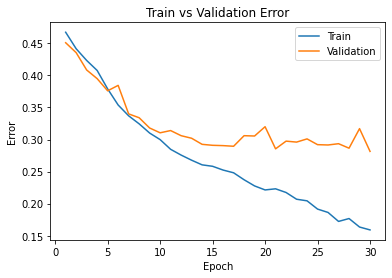

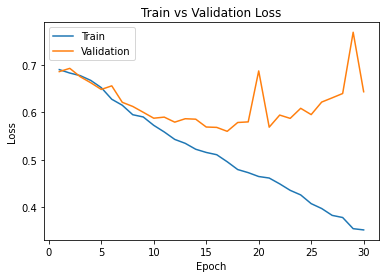

In [0]:
small_model_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
large_model_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)

plot_training_curve(small_model_path)
plot_training_curve(large_model_path)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

In [22]:
"""
For both samall_net and large_net, the training curve on the loss and error graphs decreases as the epoch number increases.
Note that the rate of decrease is inversely proportional to the epoch (i.e. the rate of decay decreases).

On the loss graphs, the training curve for large_net appears relatively linear whereas the curve for small_net more closely resembles a decaying exponential/reciprocal.
On the error graphs, the training curve for both large_net and small_net decay but the large_net curve flattens into a linear shape whereas the small_net curve keeps a decaying exponential/reciprocal form.

On the error graphs, the validation curve for small_net decreases in a similar fashion to the training data
 (although the final error is still higher than the corresponding value for the training curve, and the rate of decrease is not as high).
For large_net, the validation curve seems to plateau off around 15~20 epochs.

On the loss graphs, the validation curve for small_net decreases in a similar fashion to the training data
 (although the final loss is still higher than the corresponding value for the training curve, and the rate of decrease is not as high).
For large_net, the loss was minimized around 15 epochs before increasing continually until 30 epochs. This signifies that the model overfitted onto the training data (also explains why the training curve is linear).

At low epochs, both small_net and large_net underfit their curves.
"""

'\nFor both samall_net and large_net, the training curve on the loss and error graphs decreases as the epoch number increases.\nNote that the rate of decrease is inversely proportional to the epoch (i.e. the rate of decay decreases).\n\nOn the loss graphs, the training curve for large_net appears relatively linear whereas the curve for small_net more closely resembles a decaying exponential/reciprocal.\nOn the error graphs, the training curve for both large_net and small_net decay but the large_net curve flattens into a linear shape whereas the small_net curve keeps a decaying exponential/reciprocal form.\n\nOn the error graphs, the validation curve for small_net decreases in a similar fashion to the training data\n (although the final error is still higher than the corresponding value for the training curve, and the rate of decrease is not as high).\nFor large_net, the validation curve seems to plateau off around 15~20 epochs.\n\nOn the loss graphs, the validation curve for small_net 

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360023498535 |Validation err: 0.467, Validation loss: 0.6924686655402184
Epoch 2: Train err: 0.448625, Train loss: 0.6922589688301086 |Validation err: 0.4305, Validation loss: 0.6916493382304907
Epoch 3: Train err: 0.43575, Train loss: 0.6916067261695862 |Validation err: 0.4285, Validation loss: 0.6908544152975082
Epoch 4: Train err: 0.43, Train loss: 0.6908614072799683 |Validation err: 0.4245, Validation loss: 0.6896600145846605
Epoch 5: Train err: 0.434375, Train loss: 0.689919647693634 |Validation err: 0.4195, Validation loss: 0.6886944100260735
Epoch 6: Train err: 0.435875, Train loss: 0.6887412457466126 |Validation err: 0.4195, Validation loss: 0.6867826543748379
Epoch 7: Train err: 0.43675, Train loss: 0.6873777341842652 |Validation err: 0.418, Validation loss: 0.6851988434791565
Epoch 8: Train err: 0.437375, Train loss: 0.6859265742301941 |Validation err: 0.

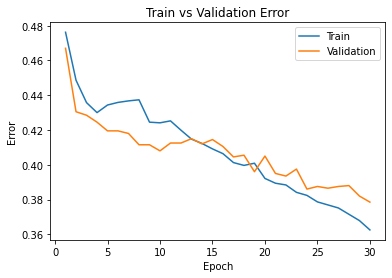

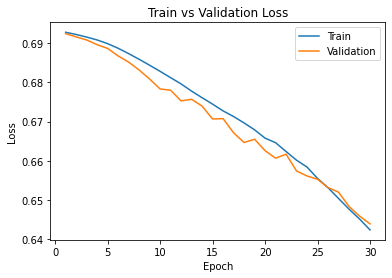

'\nTraining time increased by ~3.92 seconds.\nThe error for both training and validation sets increased. Both curves initally dip and increase momentarily before finally continually decreasing.\nThe loss for the training set increased while the loss for the validation set decreased.\nBoth loss curves are nearly identical, with the validation slightly lower (indicating lower loss) until an epoch of 25, at which point the training data has lower loss.\nThe loss curves mimic a decaying logarithm. Note that the loss barely changes across epochs.\n'

In [190]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()

train_net(large_net, learning_rate=0.001)
large_model_path = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(large_model_path)

"""
Training time increased by ~7.12 seconds.
The error for both training and validation sets increased. Both curves initally dip and increase momentarily before finally continually decreasing.
The loss for the training set increased while the loss for the validation set decreased.
Both loss curves are nearly identical, with the validation slightly lower (indicating lower loss) until an epoch of 25, at which point the training data has lower loss.
The loss curves mimic a decaying logarithm. Note that the loss barely changes across epochs.
"""

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.426875, Train loss: 0.6742900676727295 |Validation err: 0.3695, Validation loss: 0.6364889536052942
Epoch 2: Train err: 0.361625, Train loss: 0.6373908457756042 |Validation err: 0.3655, Validation loss: 0.6439082939177752
Epoch 3: Train err: 0.371625, Train loss: 0.6370397086143493 |Validation err: 0.3515, Validation loss: 0.6133540160953999
Epoch 4: Train err: 0.348, Train loss: 0.6141975626945496 |Validation err: 0.3365, Validation loss: 0.6044933125376701
Epoch 5: Train err: 0.333875, Train loss: 0.6029216282367706 |Validation err: 0.3245, Validation loss: 0.5935317613184452
Epoch 6: Train err: 0.3175, Train loss: 0.5871682240962982 |Validation err: 0.324, Validation loss: 0.5884642750024796
Epoch 7: Train err: 0.308, Train loss: 0.5718630583286285 |Validation err: 0.3095, Validation loss: 0.5934673277661204
Epoch 8: Train err: 0.306625, Train loss: 0.5659790558815002 |Validation err: 0

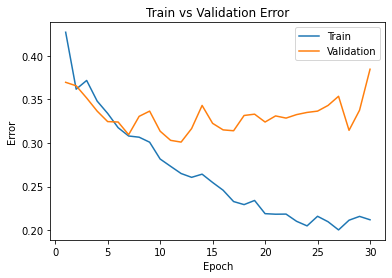

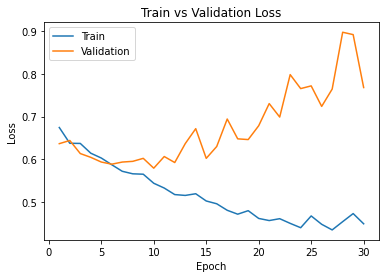

'\nTraining time increased by ~8.58 seconds.\nThe error for the training set decreased while the error for the validation set increased. The shape of the training curve resembles its 0.001 learning rate counterpart \n but the new validation curve decreased to minimize around 5 or 10 epochs but irregularly increasing. \nThe loss for the training and validation sets increased. The training curve looks like a flattened decaying exponential\n whereas the validation curve decreased to a minimum value around 5 epochs before exponentially increasing.\n'

In [191]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()

train_net(large_net, learning_rate=0.1)
large_model_path = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(large_model_path)

"""
Training time increased by ~3.08 seconds.
The error for the training set decreased while the error for the validation set increased. The shape of the training curve resembles its 0.001 learning rate counterpart 
 but the new validation curve decreased to minimize around 5 or 10 epochs before irregularly increasing. 
The loss for the training and validation sets increased. The training curve looks like a flattened decaying exponential
 whereas the validation curve decreased to a minimum value around 5 epochs before exponentially increasing.
"""

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379403591156 |Validation err: 0.478, Validation loss: 0.6926823854446411
Epoch 2: Train err: 0.457625, Train loss: 0.6924103908240795 |Validation err: 0.434, Validation loss: 0.6917425096035004
Epoch 3: Train err: 0.437, Train loss: 0.6916500441730022 |Validation err: 0.4265, Validation loss: 0.6909130066633224
Epoch 4: Train err: 0.433625, Train loss: 0.6908450052142143 |Validation err: 0.424, Validation loss: 0.6897870898246765
Epoch 5: Train err: 0.434, Train loss: 0.6896936446428299 |Validation err: 0.424, Validation loss: 0.6881358623504639
Epoch 6: Train err: 0.43825, Train loss: 0.6883534081280231 |Validation err: 0.428, Validation loss: 0.68601293861866
Epoch 7: Train err: 0.439375, Train loss: 0.6866869702935219 |Validation err: 0.426, Validation loss: 0.6836968064308167
Epoch 8: Train err: 0.435375, Train loss: 0.6849769502878189 |Validation err: 0.412, V

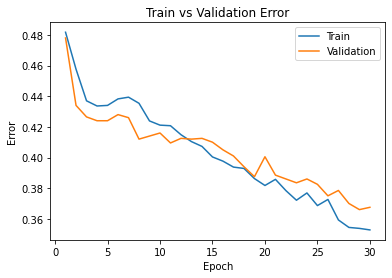

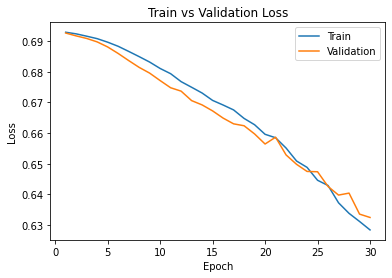

"\nTraining time decreased by ~7.91 seconds.\nThe error for the training and validation set increased. The curves have a pattern to their shape but can't be classified as a simple shape such as a decaying exponential.\nThe loss for the training set increased while the loss for the validation set decreased.\nBoth loss curves are nearly identical, with the validation slightly lower (indicating lower loss) until an epoch of 25, at which point the training data has lower loss.\nThe loss curves mimic a decaying logarithm. Note that the loss barely changes across epochs.\n"

In [192]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()

train_net(large_net, batch_size=512)
large_model_path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(large_model_path)

"""
Training time decreased by ~13.09 seconds.
The error for the training and validation set increased. The curves have a pattern to their shape but can't be classified as a simple shape such as a decaying exponential.
The loss for the training set increased while the loss for the validation set decreased.
Both loss curves are nearly identical, with the validation slightly lower (indicating lower loss) until an epoch of 25, at which point the training data has lower loss.
The loss curves mimic a decaying logarithm. Note that the loss barely changes across epochs.
"""

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774821187257767 |Validation err: 0.378, Validation loss: 0.651921395778656
Epoch 2: Train err: 0.36875, Train loss: 0.6395755406022072 |Validation err: 0.3595, Validation loss: 0.6264406447410583
Epoch 3: Train err: 0.33875, Train loss: 0.6120929001569748 |Validation err: 0.3475, Validation loss: 0.6289729187488556
Epoch 4: Train err: 0.314375, Train loss: 0.5869516692757607 |Validation err: 0.3545, Validation loss: 0.6142054274082184
Epoch 5: Train err: 0.3115, Train loss: 0.5694829801917076 |Validation err: 0.312, Validation loss: 0.5763112711906433
Epoch 6: Train err: 0.281125, Train loss: 0.5458917077481746 |Validation err: 0.2985, Validation loss: 0.5741617560386658
Epoch 7: Train err: 0.269875, Train loss: 0.5297637034058571 |Validation err: 0.309, Validation loss: 0.6013907868862152
Epoch 8: Train err: 0.257375, Train loss: 0.5129605046510697 |Validation err: 0

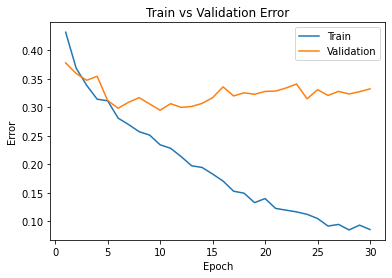

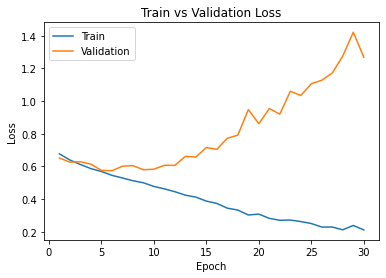

'\nTraining time increased by ~49.5 seconds. \nThe error for the training curve decreased and its shape looks like a decaying exponential.\nThe error for the validation curve increased overall. First it decreased to minimize around 5 or 10 epochs before irregularly increasing.\nThe loss for the testing curve decreased while the loss for the validation curve increased. The testing curve looks like two connected linear curves with negative slopes; the first having a more negative slope.\nThe validation curve exponentially increased.\n'

In [193]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()

train_net(large_net, batch_size=16)
large_model_path = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(large_model_path)

"""
Training time increased by ~58.31 seconds. 
The error for the training curve decreased and its shape looks like a decaying exponential.
The error for the validation curve increased overall. First it decreased to minimize around 5 or 10 epochs before irregularly increasing.
The loss for the testing curve decreased while the loss for the validation curve increased. The testing curve looks like two connected linear curves with negative slopes; the first having a more negative slope.
The validation curve exponentially increased.
"""

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

In [23]:
"""
The lowest validation error rate occured in the baseline large_net case at epoch = 24.
To try to improve this, I will slightly decrease batch size to 32 for a sharper loss average, which may more quickly optimize the model in the right direction.
"""

'\nThe lowest validation error rate occured in the baseline large_net case at epoch = 24.\nTo try to improve this, I will slightly decrease batch size to 32 for a sharper loss average, which may more quickly optimize the model in the right direction.\n'

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.447625, Train loss: 0.6850859241485596 |Validation err: 0.4095, Validation loss: 0.6715219219525655
Epoch 2: Train err: 0.385125, Train loss: 0.6621165516376495 |Validation err: 0.3725, Validation loss: 0.6446243997604127
Epoch 3: Train err: 0.361375, Train loss: 0.6363008983135223 |Validation err: 0.348, Validation loss: 0.6213002975970979
Epoch 4: Train err: 0.341375, Train loss: 0.6120481569766998 |Validation err: 0.345, Validation loss: 0.6242239929380871
Epoch 5: Train err: 0.3195, Train loss: 0.5915817145109177 |Validation err: 0.316, Validation loss: 0.593362948251149
Epoch 6: Train err: 0.299875, Train loss: 0.57114266872406 |Validation err: 0.335, Validation loss: 0.6284947045265682
Epoch 7: Train err: 0.297375, Train loss: 0.5610119928121566 |Validation err: 0.3115, Validation loss: 0.5843207183338347
Epoch 8: Train err: 0.283125, Train loss: 0.5430752960443497 |Validation err: 0

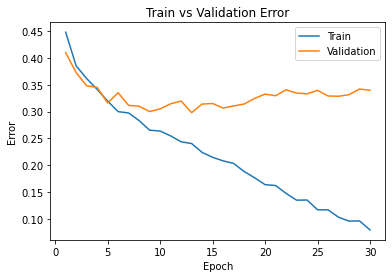

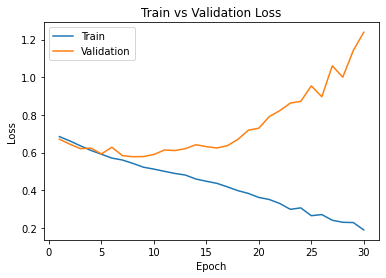

In [219]:
large_net = LargeNet()
train_net(large_net, batch_size=32, learning_rate=0.01)
large_model_path = get_model_name("large", batch_size=32, learning_rate=0.01, epoch=29)
plot_training_curve(large_model_path)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

In [24]:
"""
The decreased batch rate made things worse so I will try slightly increasing the learning rate for increased maneuverability.
"""

'\nThe decreased batch rate made things worse so I will try slightly increasing the learning rate for increased maneuverability.\n'

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.44975, Train loss: 0.6858179450035096 |Validation err: 0.41, Validation loss: 0.672688564285636
Epoch 2: Train err: 0.39325, Train loss: 0.6653169703483581 |Validation err: 0.408, Validation loss: 0.6649374477565289
Epoch 3: Train err: 0.362, Train loss: 0.6413537855148316 |Validation err: 0.355, Validation loss: 0.6253621522337198
Epoch 4: Train err: 0.3375, Train loss: 0.6146672644615173 |Validation err: 0.3705, Validation loss: 0.6516917906701565
Epoch 5: Train err: 0.322, Train loss: 0.594773418188095 |Validation err: 0.325, Validation loss: 0.6053855679929256
Epoch 6: Train err: 0.3055, Train loss: 0.5738439211845398 |Validation err: 0.3255, Validation loss: 0.6124910488724709
Epoch 7: Train err: 0.3015, Train loss: 0.5667073163986206 |Validation err: 0.314, Validation loss: 0.5922728795558214
Epoch 8: Train err: 0.288375, Train loss: 0.5473221461772919 |Validation err: 0.329, Validat

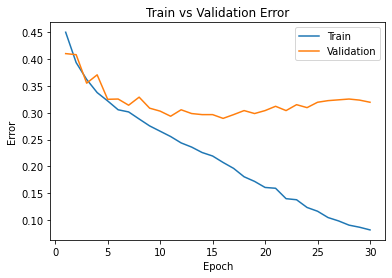

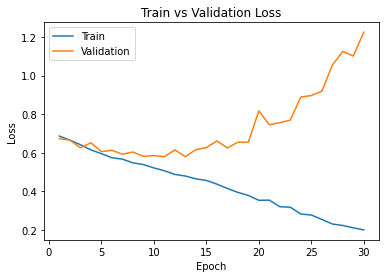

In [220]:
large_net = LargeNet()
train_net(large_net, batch_size=64, learning_rate=0.02)
large_model_path = get_model_name("large", batch_size=64, learning_rate=0.02, epoch=29)
plot_training_curve(large_model_path)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [221]:
net = LargeNet()
model_path = get_model_name(net.name, batch_size=64, learning_rate=0.01, epoch=23) # epoch = 23 corresponds to the 24th epoch
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

In [25]:
"""
Firstly, regarding small_net vs large_net, for best performance, one must use large_net as the error rates are slightly lower than its small_net counterpart.
The decisions regarding learning rate and batch size are made using the comparisons performed with a large_net model.
As previously stated, changing the learning rate to 0.001 or 0.1 negatively impacted validation accuracy.
Therefore, it is kept at 0.01. Furthermore, the default batch size of 64 minimized the validation error the fastest and greatest (the minimum value of 0.277 is reached at an epoch of 24).
"""

'\nFirstly, regarding small_net vs large_net, for best performance, one must use large_net as the error rates are slightly lower than its small_net counterpart.\nThe decisions regarding learning rate and batch size are made using the comparisons performed with a large_net model.\nAs previously stated, changing the learning rate to 0.001 or 0.1 negatively impacted validation accuracy.\nTherefore, it is kept at 0.01. Furthermore, the default batch size of 64 minimized the validation error the fastest and greatest (the minimum value of 0.277 is reached at an epoch of 24).\n'

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [226]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=64)

criterion = nn.BCEWithLogitsLoss()
test_error, test_loss = evaluate(net, test_loader, criterion)

print(test_error, test_loss)

"""
The test classification error is 0.265
"""

Files already downloaded and verified
Files already downloaded and verified
0.265 0.5621946193277836


'\nThe test classification error is 0.265\n'

### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

In [237]:
val_error, val_loss = evaluate(net, val_loader, criterion)

print(val_error, val_loss)

"""
Test classification error: 0.265
Validation error: 0.277

The test error is expected to be higher than the validation error.
While the validation set was not used to directly modify the weight optimization, this model was chosen because of its accuracy performance on the validation set.
Therefore, in a sense, I, the user, indirectly altered the model's ability to perform on that set of data.
The testing set has not yet been seen by the model or I.
As such, the model's accuracy performance using this data demonstrates its true ability to correctly predict an outcome given a new, unseen set of data.

By chance, this particular model happened to be optimized quite well and thus the test error is lower than the validation error. This is of course not to be expected.
"""

0.277 0.5920221507549286


"\nTest classification error: 0.265\nValidation error: 0.277\n\nThe test error is expected to be higher than the validation error.\nWhile the validation set was not used to directly modify the weight optimization, this model was chosen because of its accuracy performance on the validation set.\nTherefore, in a sense, I, the user, indirectly altered the model's ability to perform on that set of data.\nThe testing set has not yet been seen by the model or I.\nAs such, the model's accuracy performance using this data demonstrates its true ability to correctly predict an outcome given a new, unseen set of data.\n\nBy chance, this particular model happened to be optimized quite well and thus the test error is lower than the validation error. This is of course not to be expected.\n"

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

In [26]:
"""
As previously explained, using the test data at the very end allows us to accurately determine the model's ability to correctly predict an outcome given new, unseen data.
If this data was utilised beforehand, either by the user or the model, any indirect or direct modifications to the model to fit this new set of type would undermine the later test of determining how effective our network is.
The model is effectively overfitting itself onto the samples it is given instead of properly deducing any patterns in the data set.
"""

"\nAs previously explained, using the test data at the very end allows us to accurately determine the model's ability to correctly predict an outcome given new, unseen data.\nIf this data was utilised beforehand, either by the user or the model, any indirect or direct modifications to the model to fit this new set of type would undermine the later test of determining how effective our network is.\nThe model is effectively overfitting itself onto the samples it is given instead of properly deducing any patterns in the data set.\n"

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

In [0]:
def evaluate_ann(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs).squeeze(1)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

def train_ann(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs).squeeze(1)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate_ann(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
    test_error, test_loss = evaluate_ann(net, test_loader, criterion)
    print("Test error: {0}\tTest loss: {1}".format(test_error, test_loss))
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

In [30]:
# define a 2-layer artificial neural network
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.name = "ann"
        self.layer1 = nn.Linear(32 * 32 * 3, 50)
        self.layer2 = nn.Linear(50, 1)
    def forward(self, img):
        flattened = torch.flatten(img, start_dim=1).view(-1, 32 * 96)
        activation1 = F.relu(self.layer1(flattened))
        activation2 = self.layer2(activation1)
        return activation2

ann = ANN()

train_ann(ann, batch_size=16, learning_rate=0.001, num_epochs=30)

"""
As you can see, despite optimising the ANN hyperparameters to the best of my abilities, this networks still performed worse than the CNN model.
The ANN model is used as an introduction to machine learning whereas the CNN is a more complex model that naturally leads to better predictions.
"""

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.406375, Train loss: 0.6646861332058907 |Validation err: 0.3935, Validation loss: 0.6540009775161744
Epoch 2: Train err: 0.375125, Train loss: 0.6438644251227379 |Validation err: 0.3905, Validation loss: 0.652395512342453
Epoch 3: Train err: 0.36025, Train loss: 0.6332591949105263 |Validation err: 0.381, Validation loss: 0.6436866898536682
Epoch 4: Train err: 0.347125, Train loss: 0.6223804985880852 |Validation err: 0.394, Validation loss: 0.6547978835105897
Epoch 5: Train err: 0.334, Train loss: 0.6133039898872376 |Validation err: 0.38, Validation loss: 0.6403937644958496
Epoch 6: Train err: 0.327125, Train loss: 0.6004680503606796 |Validation err: 0.3905, Validation loss: 0.6557452347278595
Epoch 7: Train err: 0.31175, Train loss: 0.5906770250797272 |Validation err: 0.3685, Validation loss: 0.6404587721824646
Epoch 8: Train err: 0.30625, Train loss: 0.5797783367037773 |Validation err: 0.3

'\nAs \n'